In [1]:
import json
import os
import numpy as np
from PIL import Image
import random
import torch
import wandb
from torchvision import transforms as tfms

from mvdream.camera_utils import get_camera, create_camera_to_world_matrix, normalize_camera

# Prevent kernel crash
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set static seed
random.seed(0)

In [2]:
class ModelHyperParameters():
    def __init__(self, sample_size=5, step=50, scale = 5, ddim_eta=0.5, temperature = 0.01, noise_dropout = 0.0, text="Toy T-rex", size=256):
        self.sample_size = sample_size
        self.step = step
        self.scale = scale
        self.ddim_eta = ddim_eta
        self.temperature = temperature
        self.noise_dropout = noise_dropout
        self.text = text
        self.size = 256



In [3]:
class WandbParameters():
    def __init__(self, group="Group 1", job_type="inference"):
        self.group = group
        self.job_type = job_type

In [4]:
class Frame():
    def __init__(self, dataRoot, frameCfg):
        self.fpath = os.path.join(dataRoot, frameCfg["file_path"])
        self.fpath = self.fpath.replace("/", "\\") + ".png"

        # Open the image using PIL (Pillow)
        self.img = np.array(Image.open(self.fpath))

        self.PILimg = Image.fromarray(self.img)

        # Crop to get 1x1 aspect ratio
        self.ScaledPILimg = self._crop_center(1024, 1024)

        # Downscale image to required model input size (256, 256)
        self.ScaledPILimg.thumbnail((256, 256), resample=Image.Resampling.BICUBIC)

        # Save model ready image with opacity ignored
        self.modelReadyNPimg = np.array(self.ScaledPILimg)[:, :, :3]
        self.modelReadyPILimg = Image.fromarray(self.modelReadyNPimg)

        # Calculate cameraToWorld
        self.cameraToWorld = np.array(frameCfg["transform_matrix"]).astype(np.float32)

        # Align input camera poses with unit sphere.
        self.cameraToWorld = normalize_camera(self.cameraToWorld).reshape(4,4)

    def _crop_center(self, w = 1024, h = 1024) -> Image:
        # Get the current size of the image
        current_width, current_height = self.PILimg.size

        # Calculate the coordinates for cropping
        left = (current_width - w) // 2
        top = (current_height - h) // 2
        right = (current_width + w) // 2
        bottom = (current_height + h) // 2

        cropped_image = self.PILimg.crop((left, top, right, bottom))

        return cropped_image


In [5]:
class CameraExtrinsics():
    def __init__(self, paramDict):
        self.camera_angle_x = paramDict["camera_angle_x"]
        self.camera_angle_y = paramDict["camera_angle_y"]
        self.fl_x = paramDict["fl_x"]
        self.fl_y = paramDict["fl_y"]
        self.k1 = paramDict["k1"]
        self.k2 = paramDict["k2"]
        self.p1 = paramDict["p1"]
        self.p2 = paramDict["p2"]
        self.cx = paramDict["cx"]
        self.cy = paramDict["cy"]
        self.w = paramDict["w"]
        self.h = paramDict["h"]
        self.aabb_scale = paramDict["aabb_scale"]

In [6]:
class DS():
    def __init__(self, datasetDir = "..\\..\\dissertation_template\\data\\ScanNeRF", dataClass = "trex\\trex", dataMode = "transparent_bck"):
        self.datasetDir = datasetDir
        self.dataClass = dataClass
        self.dataMode = dataMode

        self.dataRoot = os.path.join(os.pardir, datasetDir, dataClass, dataMode)

        self.trainDS, self.trainExtrinsics = self._load_dataset(self.dataRoot, "train")
        self.valDS, self.valExtrinsics = self._load_dataset(self.dataRoot, "val")

    def _load_from_json(self, path):
        with open(path) as f:
            return json.load(f)
        
    # Load data split
    def _load_dataset(self, rootdir, split) -> ([Frame], [CameraExtrinsics]):
        # Load camera intrinsics for each frame, extrinsics.
        cameraCfg = self._load_from_json(os.path.join(rootdir, f"transforms_{split}.json"))

        # Initialize a list to store the loaded images
        loaded_transforms = []

        # Iterate through the poses
        for frameCfg in cameraCfg["frames"]:
            loaded_transforms.append(Frame(self.dataRoot, frameCfg))
        
        return loaded_transforms, CameraExtrinsics(cameraCfg)
    
    def _getRandomFrames(self, ds, n) -> [Frame]:
        return random.sample(ds, n)

    def _sample_frames(self, ds, frames=None) -> [Frame]:
        if frames is None:
            frames = self._getRandomFrames(ds, 4)
        return frames
    
    def sample_train(self, frames=None) -> [Frame]:
        return self._sample_frames(self.trainDS, frames)
    
    def sample_val(self, frames=None) -> [Frame]:
        return self._sample_frames(self.valDS, frames)

In [7]:
class Out():
    def __init__(self, outName):
        self.experimentPath = f"../out/{outName}"
        os.makedirs(self.experimentPath, exist_ok=True)

    def saveNPstrip(self, fname, NPimgs):
        strip = np.concatenate(NPimgs, 1)
        stripIMG = Image.fromarray(strip)

        stripIMG.save(f"{self.experimentPath}/{fname}.png")
        stripIMG

    def savePILstrip(self, fname, PILimgs):
        NPimgs = [np.array(img) for img in PILimgs]
        self.saveNPstrip(fname, NPimgs)

    def saveFig(self, fig, fname):
        fig.savefig(f"{self.experimentPath}/{fname}.png")

In [8]:
class Experiment():
    def __init__(self, experimentName = "experiment_1"):
        self.experimentName = experimentName

        self.out = Out(experimentName)
        self.modelHyperParams = ModelHyperParameters()
        self.wandbParams = WandbParameters()
        self.DS = DS()

e = Experiment()

In [9]:
class Batch():
    def __init__(self, exp:Experiment):
        self.exp = exp
        self.train_sampled_frames = exp.DS.sample_train(frames=[e.DS.trainDS[x] for x in [5, 6, 4, 8]])
        self.val_sampled_frames = exp.DS.sample_val()

        self.og_x0_img = self.prep_x0_img(self.train_sampled_frames)
        self.x0_img = self.BlankOutTile(self.og_x0_img.clone(), 0)
        self.latent_x0_img = None

        self.saveInitialState()

    # Prepare images to be converted to latent space by converting to tensor and stacking into [4, 3, 256, 256] shape with values scaled to [0.0, 1.0]
    def prep_x0_img(self, frames):
        imgs = []

        for frame in frames:
            init_image = tfms.ToTensor()(frame.modelReadyPILimg)
            imgs.append(init_image)

        stacked_rgb = torch.stack(imgs, dim=0)
        print(f"Transposed input shape: {stacked_rgb.shape}")

        return stacked_rgb
    
    def BlankOutTile(self, x0_img, id=0):
        x0_img[id] = torch.zeros(x0_img.shape[1:])
        return x0_img

    def saveInitialState(self):
        self._save_train_frames("og_train")

    def _save_train_frames(self, fname):
        self.exp.out.saveNPstrip(fname, [f.modelReadyPILimg for f in self.train_sampled_frames])

b = Batch(e)

Transposed input shape: torch.Size([4, 3, 256, 256])


In [10]:
# Check if camera matrices match autogenerated ones
azimuth_start = 0
azimuth_span = 360
angle_gap = 30
elevation = 0

azimuths = [azimuth for azimuth in np.arange(azimuth_start, azimuth_span+azimuth_start, angle_gap)]
autogen_sampled_poses = [create_camera_to_world_matrix(elevation, azimuth) for azimuth in azimuths]

In [11]:
# Original Author: https://github.com/demul/extrinsic2pyramid/tree/main
# Visualize camera poses in scene
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

class CameraPoseVisualizer:
    def __init__(self, xlim, ylim, zlim):
        self.fig = plt.figure(figsize=(18, 7))
        self.ax = self.fig.add_subplot(projection='3d')
        self.ax.set_aspect("auto")
        self.ax.set_xlim(xlim)
        self.ax.set_ylim(ylim)
        self.ax.set_zlim(zlim)
        self.ax.set_xlabel('x')
        self.ax.set_ylabel('y')
        self.ax.set_zlabel('z')
        print('initialize camera pose visualizer')

    def extrinsic2pyramid(self, extrinsic, color='r', focal_len_scaled=5, aspect_ratio=0.3):
        vertex_std = np.array([[0, 0, 0, 1],
                               [focal_len_scaled * aspect_ratio, -focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [focal_len_scaled * aspect_ratio, focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [-focal_len_scaled * aspect_ratio, focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [-focal_len_scaled * aspect_ratio, -focal_len_scaled * aspect_ratio, focal_len_scaled, 1]])
        vertex_transformed = vertex_std @ extrinsic.T
        meshes = [[vertex_transformed[0, :-1], vertex_transformed[1][:-1], vertex_transformed[2, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[4, :-1], vertex_transformed[1, :-1]],
                            [vertex_transformed[1, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]]]
        self.ax.add_collection3d(
            Poly3DCollection(meshes, facecolors=color, linewidths=0.3, edgecolors=color, alpha=0.35))

    def customize_legend(self, list_label):
        list_handle = []
        for idx, label in enumerate(list_label):
            color = plt.cm.rainbow(idx / len(list_label))
            patch = Patch(color=color, label=label)
            list_handle.append(patch)
        plt.legend(loc='right', bbox_to_anchor=(1.8, 0.5), handles=list_handle)

    def colorbar(self, max_frame_length):
        cmap = mpl.cm.rainbow
        norm = mpl.colors.Normalize(vmin=0, vmax=max_frame_length)
        self.fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='Frame Number')

    def show(self):
        plt.title('Extrinsic Parameters')
        plt.show()

initialize camera pose visualizer


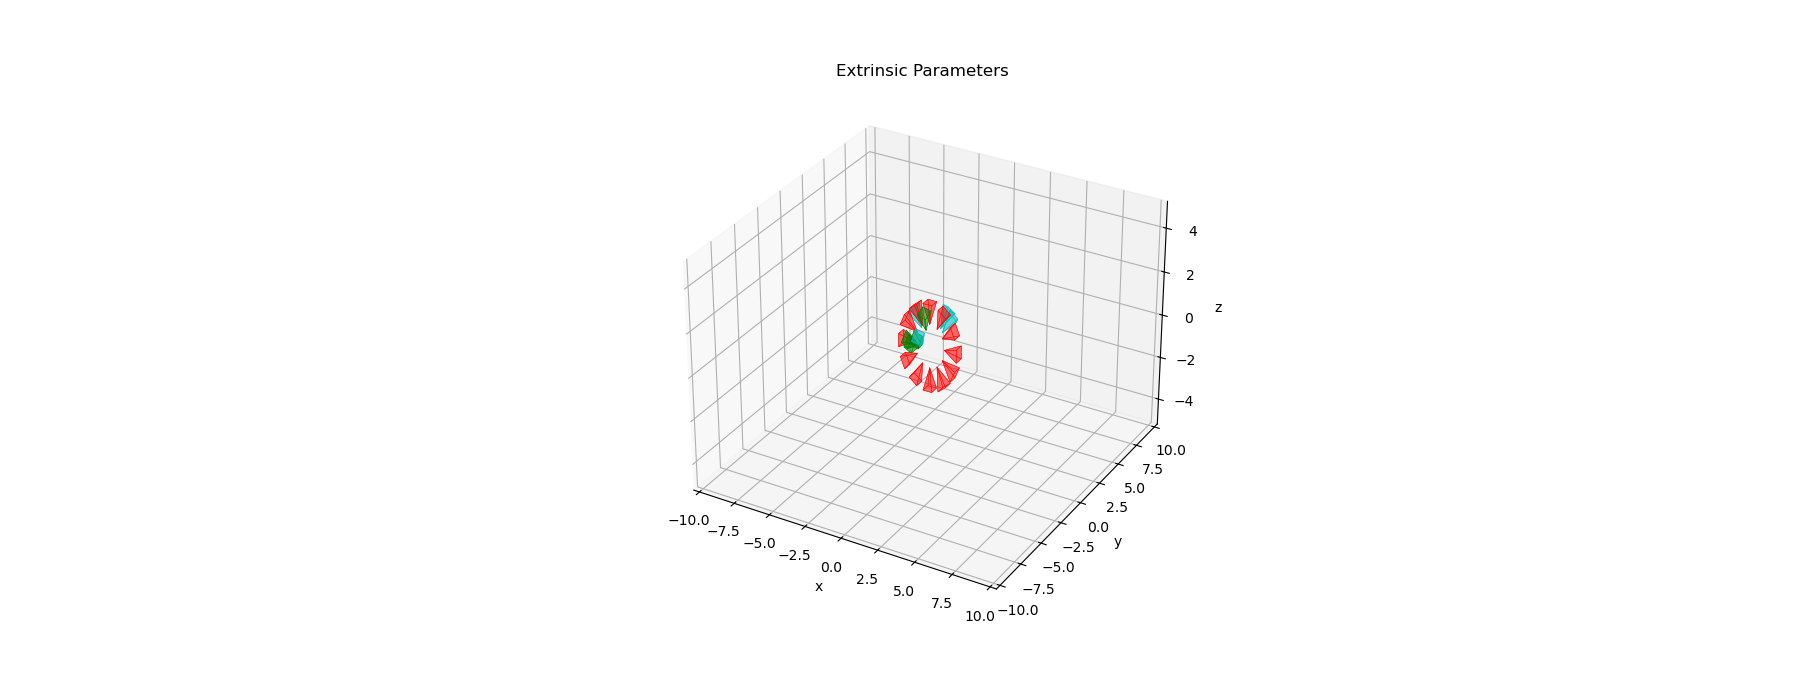

In [12]:
%matplotlib widget

# Visualize sampled camera angles in a 3D scene

visualizer = CameraPoseVisualizer([-10, 10], [-10, 10], [-5, 5])

# argument : extrinsic matrix, color, scaled focal length(z-axis length of frame body of camera
for frame in b.train_sampled_frames:
    pose = frame.cameraToWorld
    visualizer.extrinsic2pyramid(pose, 'c', 1)

for frame in b.val_sampled_frames:
    pose = frame.cameraToWorld
    visualizer.extrinsic2pyramid(pose, 'g', 1)
    
for pose in autogen_sampled_poses:
    visualizer.extrinsic2pyramid(pose, 'r', 1)

visualizer.show()

In [13]:
class Args():
    model_name='sd-v2.1-base-4view'
    config_path=None
    ckpt_path=None
    text='a toy dinosaur trex'
    suffix=', 3d asset'
    size=256
    num_frames=4
    use_camera=1
    camera_elev=15
    camera_azim=90
    camera_azim_span=360
    seed=23
    fp16=False
    device='cuda'

In [14]:
import argparse
from mvdream.model_zoo import build_model
from omegaconf import OmegaConf
from mvdream.ldm.util import instantiate_from_config
from mvdream.ldm.models.diffusion.ddim import DDIMSampler

parser = argparse.ArgumentParser()
parser.add_argument("--model_name", type=str, default="sd-v2.1-base-4view", help="load pre-trained model from hugginface")
parser.add_argument("--config_path", type=str, default=None, help="load model from local config (override model_name)")
parser.add_argument("--ckpt_path", type=str, default=None, help="path to local checkpoint")
parser.add_argument("--text", type=str, default="a toy dinosaur trex")#"an astronaut riding a horse")
parser.add_argument("--suffix", type=str, default=", 3d asset")
parser.add_argument("--size", type=int, default=256)
parser.add_argument("--num_frames", type=int, default=4, help="num of frames (views) to generate")
parser.add_argument("--use_camera", type=int, default=1)
parser.add_argument("--camera_elev", type=int, default=15)
parser.add_argument("--camera_azim", type=int, default=90)
parser.add_argument("--camera_azim_span", type=int, default=360)
parser.add_argument("--seed", type=int, default=23)
parser.add_argument("--fp16", action="store_true")
parser.add_argument("--device", type=str, default='cuda')
#args = parser.parse_args()
args = Args()

dtype = torch.float32 if args.fp16 else torch.float16
device = args.device
batch_size = max(4, args.num_frames)

print("load t2i model ... ")
if args.config_path is None:
    model = build_model(args.model_name, ckpt_path=args.ckpt_path)
else:
    assert args.ckpt_path is not None, "ckpt_path must be specified!"
    config = OmegaConf.load(args.config_path)
    model = instantiate_from_config(config.model)
    model.load_state_dict(torch.load(args.ckpt_path, map_location='cpu'))
model.device = device
model.to(device)
model.eval()

sampler = DDIMSampler(model)
uc = model.get_learned_conditioning( [""] ).to(device)
print("load t2i model done . ")

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


load t2i model ... 
Loading model from config: sd-v2-base.yaml
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 20 heads.
Setting up MemoryEfficientCrossAttention

In [15]:
import gc
torch.cuda.empty_cache()
gc.collect()

155

In [16]:
def x0_img_to_latents(init_image):
    '''
    Function to convert rescaled and reshaped x0_img to latents
    '''
    # Regularize image for VAE encoding
    init_image = init_image * 2.0 - 1.0

    init_image = init_image.to(device="cuda", dtype=torch.float32)
    print(f"init_image shape: {init_image.size()}")
    # Encode with default scaling param
    init_latent_dist = model.first_stage_model.encode(init_image).sample() * 0.18215   
    return init_latent_dist

def x0_latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents     
    with torch.no_grad():
        image = model.first_stage_model.decode(latents)#.sample #vae.decode(latents).sample
    
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")     
    pil_images = [Image.fromarray(image) for image in images]        
    return pil_images

def x0_latents_to_np(latents):
    '''
    Function to convert latents to images
    '''     
    latents = (1 / 0.18215) * latents     
    with torch.no_grad():
        image = model.first_stage_model.decode(latents)#.sample #vae.decode(latents).sample
    
    image = (image / 2 + 0.5).clamp(0, 1)     
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()      
    images = (image * 255).round().astype("uint8")       
    return images

In [17]:
# Encode 
with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
    latent_img = x0_img_to_latents(b.og_x0_img)
print(f"Dimension of this original representation: {b.og_x0_img.shape}")
print(f"Dimension of this latent representation: {latent_img.shape}")

init_image shape: torch.Size([4, 3, 256, 256])
Dimension of this original representation: torch.Size([4, 3, 256, 256])
Dimension of this latent representation: torch.Size([4, 4, 32, 32])


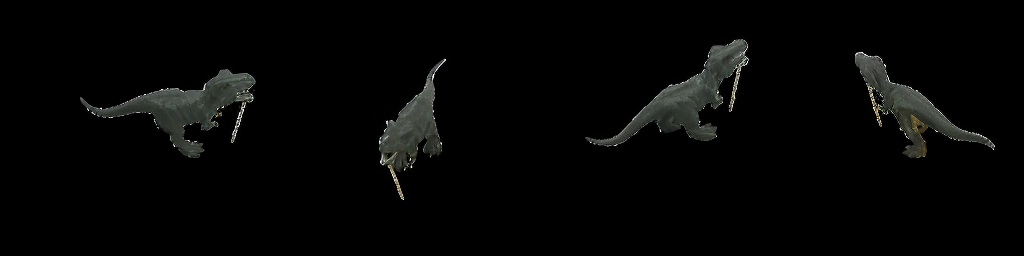

In [18]:
with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
    decoded_img = x0_latents_to_pil(latent_img)
    decoded_img[0]

decoded_img = np.concatenate(decoded_img, 1)
encodeDecode = Image.fromarray(decoded_img)
e.out.savePILstrip("EncodeDecode", [encodeDecode])

encodeDecode

In [19]:
# For comparison, test out the originad unfinetuned VAE encoder
## To import an image from a URL 
from fastdownload import FastDownload  

import torch, logging
## Imaging  library 
from PIL import Image 
## Basic libraries 
import numpy as np 
import matplotlib.pyplot as plt 

## Loading a VAE model 
from diffusers import AutoencoderKL 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float32).to("cuda")
def load_image(p):    
    return Image.open(p).convert('RGB').resize((256,256))
def pil_to_latents(image):
    '''     
    Function to convert image to latents     
    '''     
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    print(f"Transformed image shape: {init_image.shape}")
    init_image = init_image.to(device="cuda", dtype=torch.float32)
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215     
    return init_latent_dist  
def latents_to_pil(latents):     
    ''' 
    Function to convert latents to images     
    '''     
    latents = (1 / 0.18215) * latents     
    with torch.no_grad():         
        image =  vae.decode(latents).sample     
    
    image = (image / 2 + 0.5).clamp(0, 1)     
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()      
    images = (image * 255).round().astype("uint8")     
    pil_images = [Image.fromarray(image) for image in images]        
    return pil_images

def x0_img_to_latents_og_model(init_image):
    '''     
    Function to convert rescaled and reshaped x0_img to latents     
    '''
    # Regularize image for VAE encoding
    init_image = init_image * 2.0 - 1.0

    init_image = init_image.to(device="cuda", dtype=torch.float32)

    # Encode with default scaling param
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215   
    return init_latent_dist

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [20]:
import gc

torch.cuda.empty_cache()
gc.collect()
# Encode with original encoder
with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
    latent_img_base = x0_img_to_latents_og_model(b.og_x0_img)
print(f"Dimension of this original representation: {b.og_x0_img.shape}")
print(f"Dimension of this latent representation: {latent_img.shape}")

Dimension of this original representation: torch.Size([4, 3, 256, 256])
Dimension of this latent representation: torch.Size([4, 4, 32, 32])


In [21]:
torch.cuda.empty_cache()
gc.collect()

img = e.DS.trainDS[0].modelReadyPILimg

z = tfms.ToTensor()(img).unsqueeze(0) * 2.0 - 1.0
print(z.size())

z_x0 = torch.from_numpy((np.stack([img], axis=0)).transpose(0, 3, 1, 2) * 2.0 - 1.0)
print(z_x0.shape)

with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
    init_image_a = z.to(device="cuda", dtype=torch.float32)
    init_latent_dist = model.first_stage_model.encode(init_image_a).sample() * 0.18215   

with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
    init_image_b = z_x0.to(device="cuda", dtype=torch.float32)
    init_latent_dist_x0 = vae.encode(init_image_b).latent_dist.sample() * 0.18215

# tfms.ToTensor()(img) != torch.from_numpy???
init_image_a - init_image_b

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

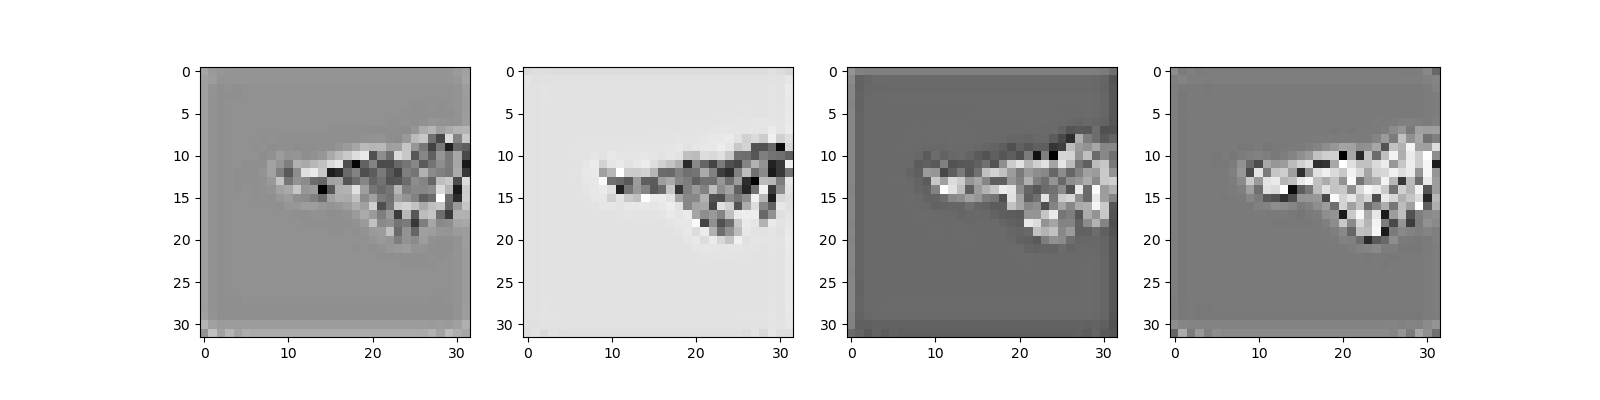

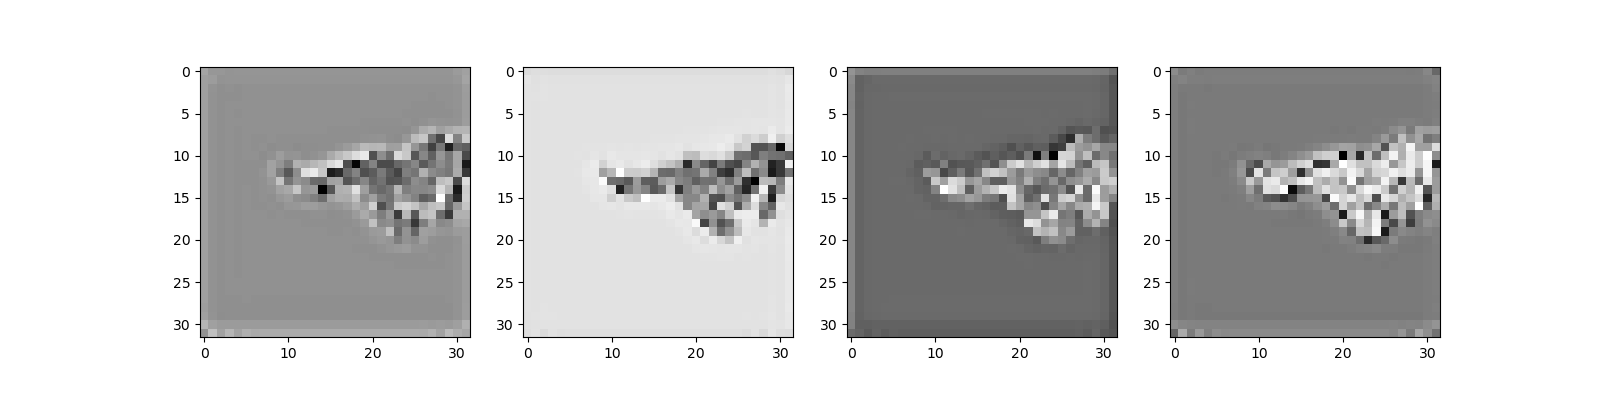

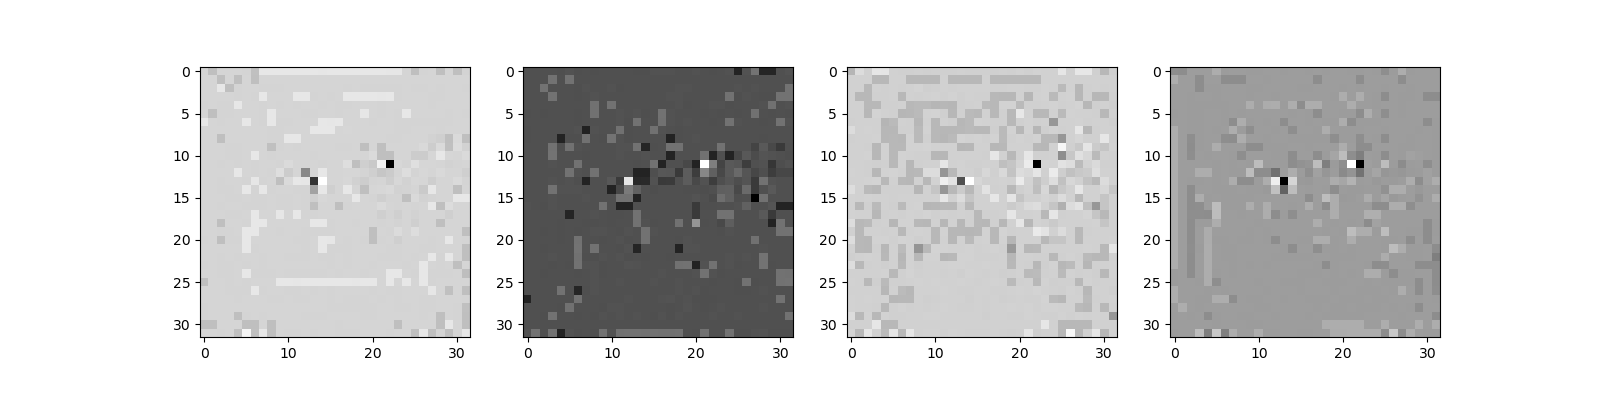

In [22]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latent_img_base[0][c].detach().cpu(), cmap='Greys')
e.out.saveFig(fig, "LatentBase")

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latent_img[0][c].detach().cpu(), cmap='Greys')
e.out.saveFig(fig, "Latent")

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latent_img[0][c].detach().cpu() - latent_img_base[0][c].detach().cpu(), cmap='Greys')
e.out.saveFig(fig, "LatentDiff")

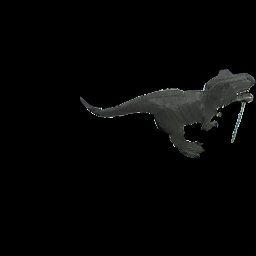

In [23]:
import gc
torch.cuda.empty_cache()
gc.collect()


latent_img[:2,:,:,:].reshape(2, 4, 32, 32).shape
decoded_img = latents_to_pil(latent_img_base[0,:,:,:].reshape(-1, 4, 32, 32))

decoded_img[0]

In [24]:
torch.cuda.empty_cache()
gc.collect()

decoded_img = x0_latents_to_pil(latent_img_base[0,:,:,:].reshape(-1, 4, 32, 32))

decoded_img[0]

calc_sim_to = decoded_img[0]

In [25]:
import torch
from PIL import Image
import open_clip

clip_model, _, clip_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')

In [26]:
def ti2i(model, image_size, prompt, uc, sampler, step=20, scale=7.5, batch_size=8, ddim_eta=0., dtype=torch.float32, device="cuda", camera=None, num_frames=1, x0=None, mask=None, temperature=1., noise_dropout=0., quantize_x0=False, verbose=False, img_callback=None, evaluate_inter=False, decode_inter=False):
    with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
        if type(prompt) == Image.Image:
            c = model.cond_stage_model.preprocess(prompt).unsqueeze(0)
            c = clip_model.encode_image(c).to(device)
            c /= c.norm(dim=-1, keepdim=True)
        else:
            if type(prompt)!=list:
                prompt = [prompt]
            c = model.get_learned_conditioning(prompt).to(device)
            
        c_ = {"context": c.repeat(batch_size,1,1)}
        uc_ = {"context": uc.repeat(batch_size,1,1)}
        if camera is not None:
            c_["camera"] = uc_["camera"] = camera
            c_["num_frames"] = uc_["num_frames"] = num_frames

        eval_callback = None
        if evaluate_inter:
            eval_callback =  img_callback

        # 4 channels of size 32x32, batch_size = 4 (4 frames per batch)
        shape = [4, image_size // 8, image_size // 8]
        samples_ddim, intermediaries = sampler.sample(S=step, conditioning=c_,
                                        batch_size=batch_size, shape=shape,
                                        verbose=verbose,
                                        log_every_t=2, 
                                        unconditional_guidance_scale=scale,
                                        unconditional_conditioning=uc_,
                                        temperature=temperature, noise_dropout=noise_dropout,
                                        quantize_x0=quantize_x0,
                                        eta=ddim_eta, x_T=None, x0=x0, mask=mask,
                                        img_callback = eval_callback)

        if img_callback:
            img_callback(samples_ddim, -1)

        decoded_intermediaries = []

        if decode_inter:  
            for inter_samples_ddim in intermediaries["x_inter"]:
                # Decode (upscale) the images
                x_sample = model.decode_first_stage(inter_samples_ddim) 
                x_sample = torch.clamp((x_sample + 1.0) / 2.0, min=0.0, max=1.0)
                x_sample = 255. * x_sample.permute(0,2,3,1).cpu().numpy()
                decoded_intermediaries.append(list(x_sample.astype(np.uint8)))

        x_sample = model.decode_first_stage(samples_ddim)
        x_sample = torch.clamp((x_sample + 1.0) / 2.0, min=0.0, max=1.0)
        x_sample = 255. * x_sample.permute(0,2,3,1).cpu().numpy()
        
    return (list(x_sample.astype(np.uint8)), decoded_intermediaries)

In [27]:
def get_camera_param(frames):
    cameras = []
    for frame in frames:
        camera_matrix = frame.cameraToWorld
        cameras.append(camera_matrix.flatten())
    return torch.tensor(np.stack(cameras, 0)).float()

initialize camera pose visualizer


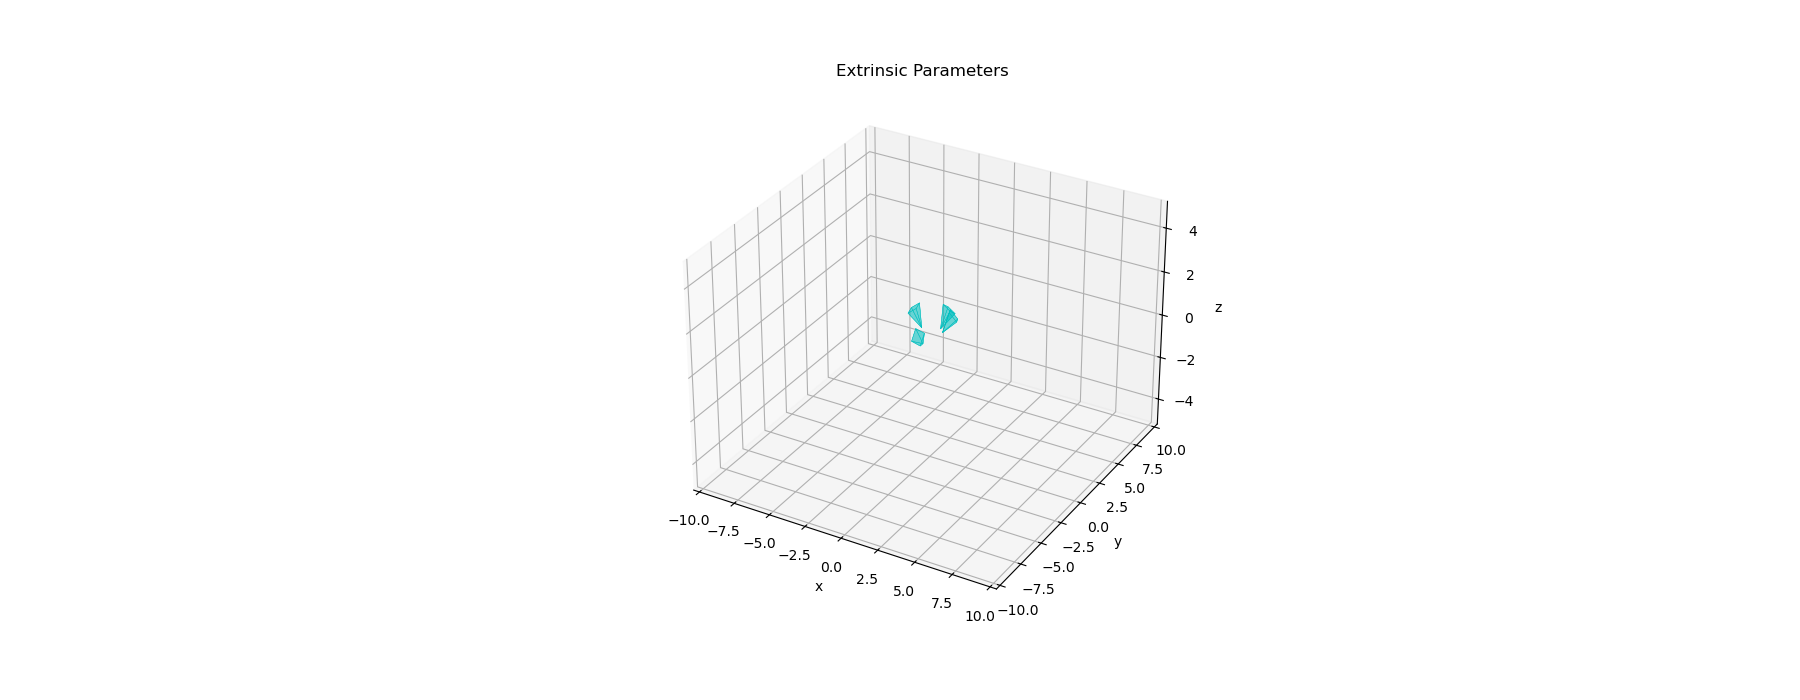

init_image shape: torch.Size([4, 3, 256, 256])
init_image shape: torch.Size([4, 3, 256, 256])


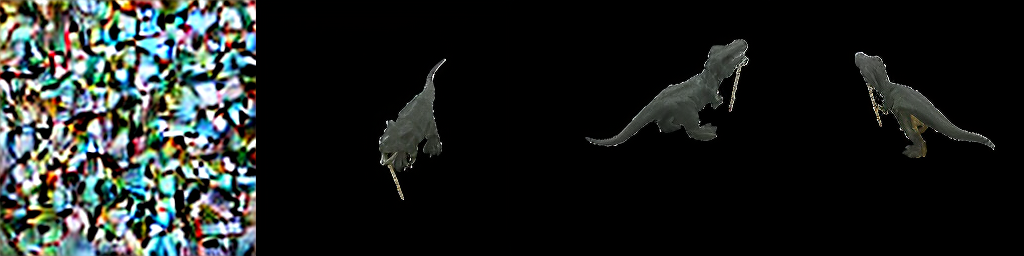

In [28]:
#train_sampled_poses = sample_pose(train_ds, poses=[train_ds[5], train_ds[6], train_ds[4], train_ds[8]])
#x0_img = prep_x0_img(train_sampled_poses)

visualizer = CameraPoseVisualizer([-10, 10], [-10, 10], [-5, 5])

# argument : extrinsic matrix, color, scaled focal length(z-axis length of frame body of camera
for frame in b.train_sampled_frames:
    c2w = frame.cameraToWorld
    visualizer.extrinsic2pyramid(c2w, 'c', 1)

visualizer.show()

with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
    og_latent_img = x0_img_to_latents(b.og_x0_img)

    # Convert to latent space and randomize masked input image (x0_img)
    b.latent_x0_img = x0_img_to_latents(b.x0_img)
    b.latent_x0_img[0] = torch.randn(latent_img.shape[1:], device=device)

with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
    og_sim_decoded = x0_latents_to_np(og_latent_img.clone())
    
    decoded_img = x0_latents_to_pil(b.latent_x0_img.clone())

decoded_img = np.concatenate(decoded_img, 1)
encodeDecode_x0 = Image.fromarray(decoded_img)

calc_sim_to = np.array(og_sim_decoded)

e.out.savePILstrip("encoded_decoded_x0_img", [encodeDecode_x0])
encodeDecode_x0

In [29]:
batch_size = max(4, args.num_frames)

# Get the camera conditioning from training images
camera = get_camera_param(b.train_sampled_frames)
camera = camera.repeat(batch_size//args.num_frames, 1).to(device)

# Get textual encoding
args.text = "Toy T-rex"
t = args.text# + args.suffix

# Get image encoding
#t = Image.fromarray(train_sampled_poses[1]['img'][:,:,:3])

with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
    latent_img = x0_img_to_latents(b.x0_img)

# Set mask
mask = torch.ones(latent_img.shape, device=device)
mask[0, :, :, :] = 0

calc_latent_sim_to = og_latent_img.clone()[0]
#print(calc_sim_to)


init_image shape: torch.Size([4, 3, 256, 256])


In [42]:
import torch
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio, LearnedPerceptualImagePatchSimilarity

ssim = StructuralSimilarityIndexMeasure().to(device)
psnr = PeakSignalNoiseRatio(data_range=1.0).to(device)
lpips = LearnedPerceptualImagePatchSimilarity(normalize=True).to(device)

metrics = {}

def calc_latent_image_metrics(run_id):
    def _calc_latent_image_metrics(pred_x0, i):
        pred_x0 = pred_x0[0].unsqueeze(0)
        target = calc_latent_sim_to.unsqueeze(0)

        ssim_metric = ssim(target, pred_x0)
        psnr_metric = psnr(target, pred_x0)

        #metrics[run_id].append({"ssim_metric": float(ssim_metric.cpu().numpy()), "psnr_metric": float(psnr_metric.cpu().numpy())})

        #lpips_metric = lpips(target, pred_x0)
        wandb.log({"latent_ssim": ssim_metric, "latent_psnr": psnr_metric}, step=run_id)
        print(f"{run_id} - {i} - ssim: {ssim_metric} psnr: {psnr_metric}") #lpips: {lpips_metric}")
    return _calc_latent_image_metrics

def calc_rgb_image_metrics(pred_x0, i):
    target = calc_sim_to
    
    target = target.transpose(0, 3, 1, 2)
    pred_x0 = pred_x0.transpose(0, 3, 1, 2)
    #ssim_metric = ssim(target, pred_x0)
   # psnr_metric = psnr(target, pred_x0)
    lpips_metric = lpips(target, pred_x0)

    wandb.log({"rgb_lpips": lpips_metric})
    print(f"{i} - lpips: {lpips_metric}")

DDIM Sampler: 100%|██████████| 50/50 [00:02<00:00, 17.93it/s]


0 - -1 - ssim: 0.405811071395874 psnr: 3.354808807373047


DDIM Sampler: 100%|██████████| 50/50 [00:05<00:00,  9.76it/s]


1 - -1 - ssim: 0.3996611535549164 psnr: 4.470602989196777


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.81it/s]


2 - -1 - ssim: 0.325158029794693 psnr: 2.9385054111480713


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.35it/s]


3 - -1 - ssim: 0.3427887558937073 psnr: 3.057933807373047


DDIM Sampler: 100%|██████████| 50/50 [00:05<00:00,  9.07it/s]


4 - -1 - ssim: 0.3089020550251007 psnr: 3.530351161956787


latent_psnr,▃█▁▂▄
latent_ssim,██▂▃▁
latent_psnr,3.53035
latent_ssim,0.3089


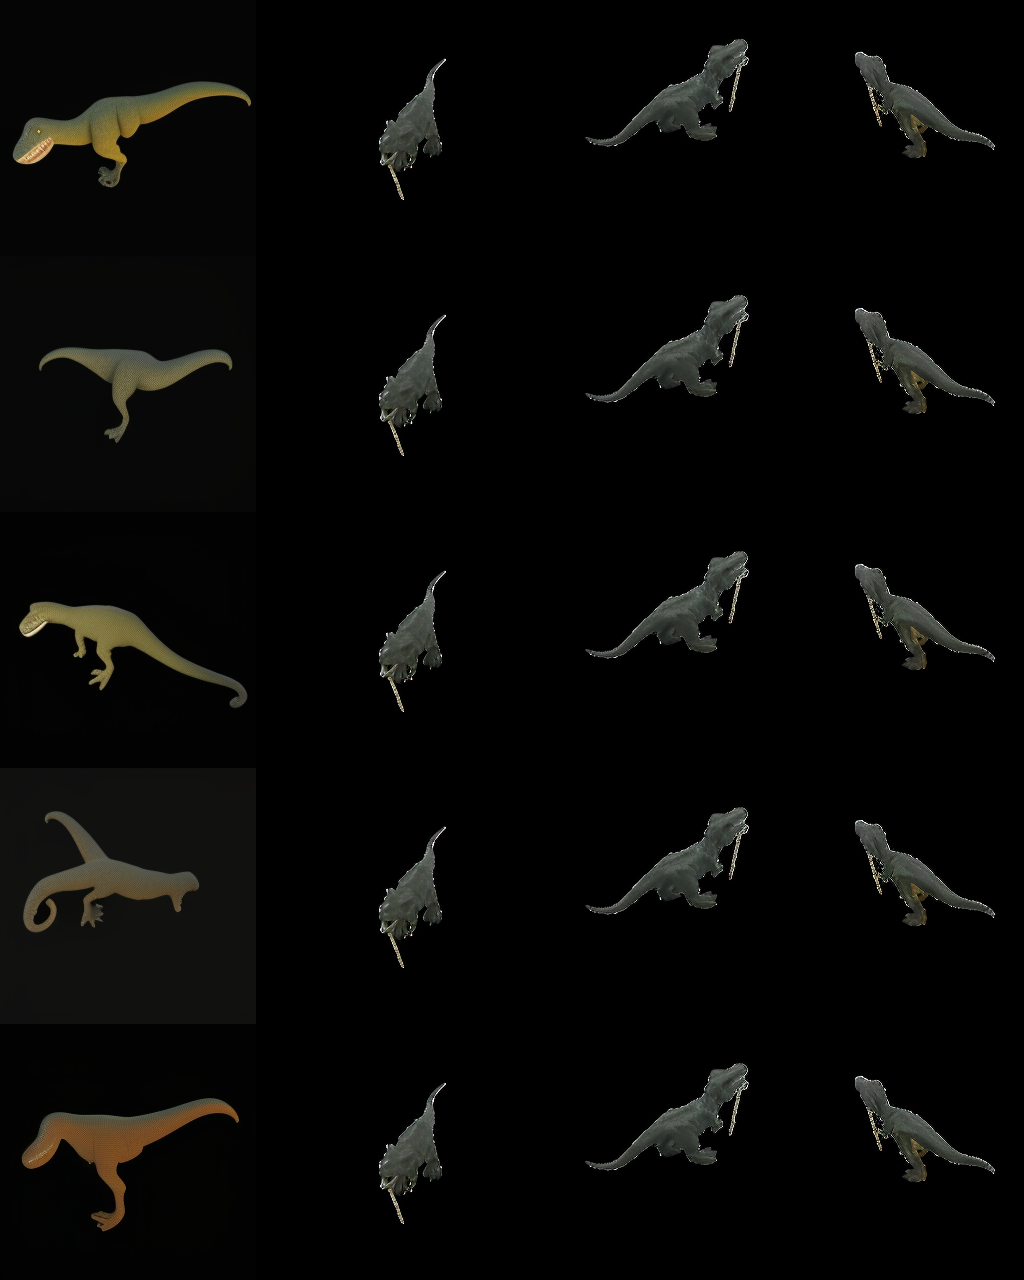

In [45]:
from dataclasses import dataclass

images = []
params = e.modelHyperParams

metrics = {}
renders = {}

wandb.init(
         # set the wandb project where this run will be logged
         project="MVDream-Inpaint",
    
         # track hyperparameters and run metadata
         config= e.wandbParams.__dict__,
         name = "experiment_3"#f"{e.experimentName}"
     )


for j in range(params.sample_size):
    metrics[j] = []
    img, inter_images = ti2i(model, params.size, params.text, uc, sampler, step=params.step, scale=params.scale, batch_size=batch_size, ddim_eta=params.ddim_eta, dtype=dtype, device=device, camera=camera, num_frames=args.num_frames, x0=latent_img, mask=mask, temperature=params.temperature, noise_dropout=params.noise_dropout, img_callback=calc_latent_image_metrics(run_id=j), evaluate_inter=False, decode_inter=False)
    # Better is: Low temperature, low scale, high ddim_eta. noise dropout inconsistent? 
    # lower temperature requires higher scale 0.0001
    #calc_rgb_image_metrics(np.array(img), -1)
    img = np.concatenate(img, 1)
    renders[j] = img
    images.append(img)
    #wandb.finish()
    wandb.log({"final_render": wandb.Image(img)}, step=j)

    for idx, inter_img in enumerate(inter_images):
        inter_images = np.concatenate(inter_img, 1)
        e.out.savePILstrip(f"Dinosaur_inter_{j}_{idx}", [Image.fromarray(inter_images)])

wandb.finish()

images = np.concatenate(images, 0)

e.out.savePILstrip(f"Final_reconstruction", [Image.fromarray(images)])

Image.fromarray(images)

In [32]:
metrics
#wandb.finish()
[metrics[m][0]["ssim_metric"] for m in metrics] 

[0.25549060106277466,
 0.3679678440093994,
 0.33548760414123535,
 0.229326069355011,
 0.3652924597263336]

In [33]:
[render for render in renders]

[0, 1, 2, 3, 4]

In [34]:
import torch
from mvdream.camera_utils import get_camera
model.eval()
model.cuda()
with torch.no_grad():
    noise = torch.randn(4,4,32,32, device="cuda") # batch of 4x for 4 views, latent size 32=256/8
    t = torch.tensor([999]*4, dtype=torch.long, device="cuda") # same timestep for 4 views
    cond = {
        "context": model.get_learned_conditioning([""]*4).cuda(), # text embeddings
        "camera": get_camera(4).cuda(),
        "num_frames": 4,
    }
    eps = model.apply_model(noise, t, cond=cond)

In [35]:
# Training images
# Validate images
# Image metrics: SSIM, LPIPS, PSNR